# Elements of parallel computing in Python

## Why parallel computing is important ?

**Because improving computation speed is now achieved in increasing the number of computational cores**

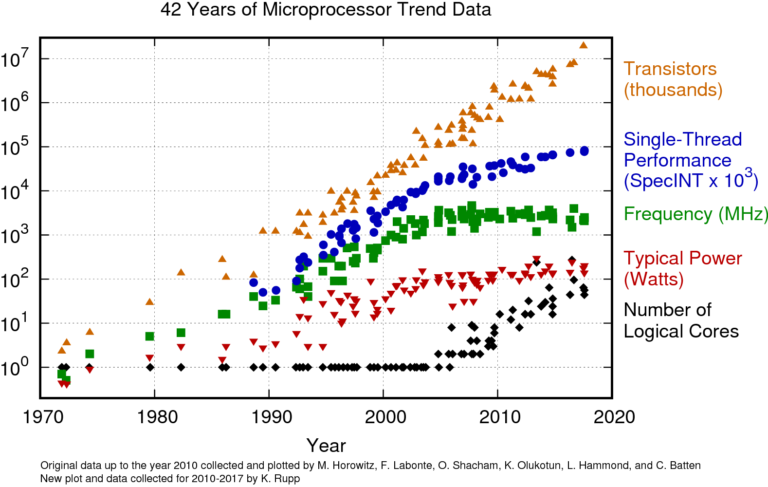


From [Karl Rupp blog](https://www.karlrupp.net/2018/02/42-years-of-microprocessor-trend-data/)

# What is in this notebook ?
**In this notebook, we will work on :**
* Parallel computing basics
  * Parallel programming issues
  * The two types of parallel computing : ditributed / shared memory
  * Simplified diagrams on memory and cores
* Three examples :
  * User friedly parallel processing
  * Parallelization in IPython (`ipyparallel`) with an exercise about parallel sorting
  * GPU computing example

### A more comprehensive course on parallel computing should include
* Details on communication tools between parallel program parts (OpenMP, MPI, ...)
* Tools inside programming languages (threads, locks / semaphores, ...)
* How to know if and how a algorithm can be parallelized
* What other hardwares can be used (supercomputers, HPC service, clusters, ...)
* Program deployment, including container use
* ...

# 1. Parallel computing basics

## 1.1 Parallel programming issues

Some parts are adapted from [Python MPI introduction](https://nyu-cds.github.io/python-mpi/01-introduction/)

Different ways of **spending time** : 
* Computation time
* Idle time - waiting for data from other processors 
* Access / Communication time - time the processors take to access the data or to send and receive messages

What are the **computing units** and their **organisation** :
* CPU / GPU
* shared or distributed memory
* ...

**Algorithm parallelization** : 
* from the easiest one (ex. estimation by simulation)
* via more difficult  (ex.2 by 2 comparisons)
* to the most difficult (ex. incemental processing, the (n+1) step needs all the n step results) 


### Amdahl’s law

$$ speedup = \frac{1}{(1-P)+\frac{P}{n}}$$
where : 
* $speedup$ is the theoretical speedup of the execution of the whole program
* $n$ is the number of parallel threads/processes
* $P$ is the fraction of the algorithm that can be made parallel


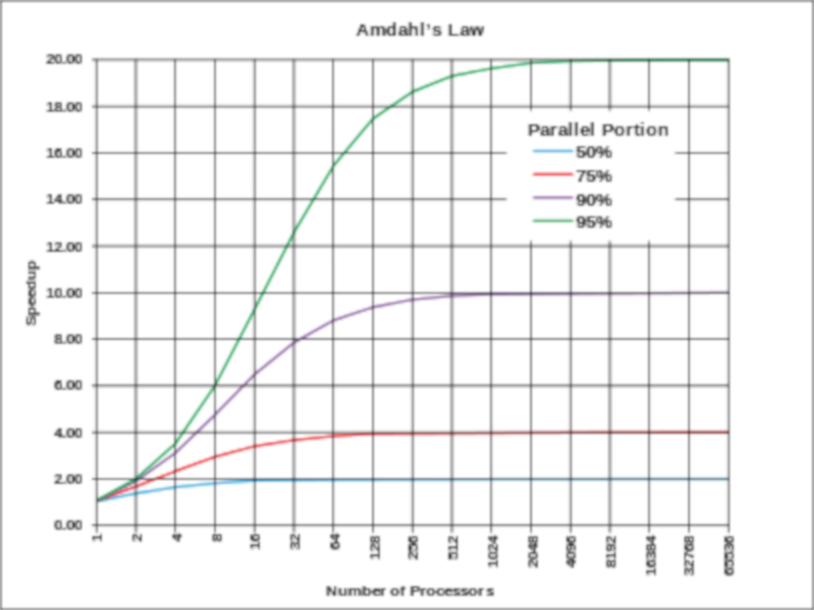

 ### What important feature is forgotten ?


access time to the data

## 1.2 Two types of parellel computing : Shared / Distributed memomry


### Shared memory parallel computing
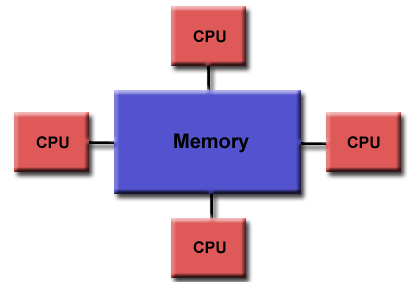

Most common tool : **OpenMP**


### Ditributed memory parallel computing
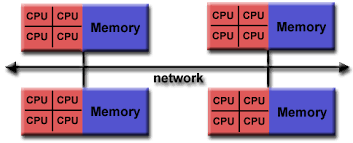

Most common tool : **MPI**

Special addintional issues : 
 * How to divide the work among the available processors according to their performances
 * Minimizing Communication (number ad size of messages)
 * Deployment


## 1.3 Architecture and memory access are important

When parallelizing an algorithm, you should take into account some features  :
* the number of units
* computing capacity of each unit
* the sizes of the different types of memory
* the time to access to theses memories
* what are the shared memories
* ...


### An Intel example 



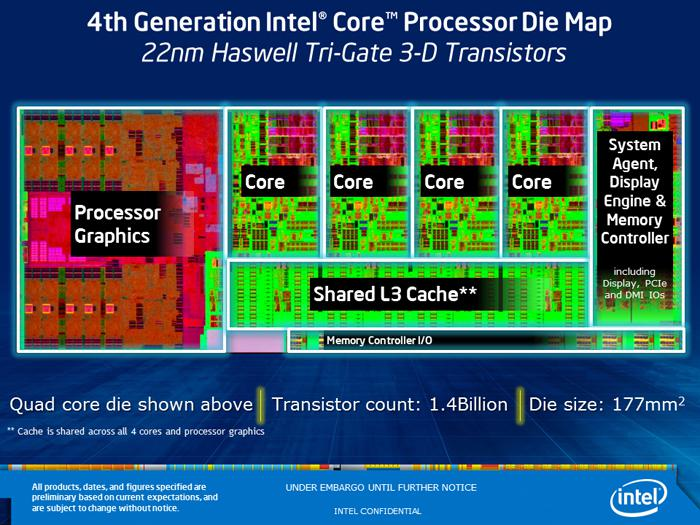

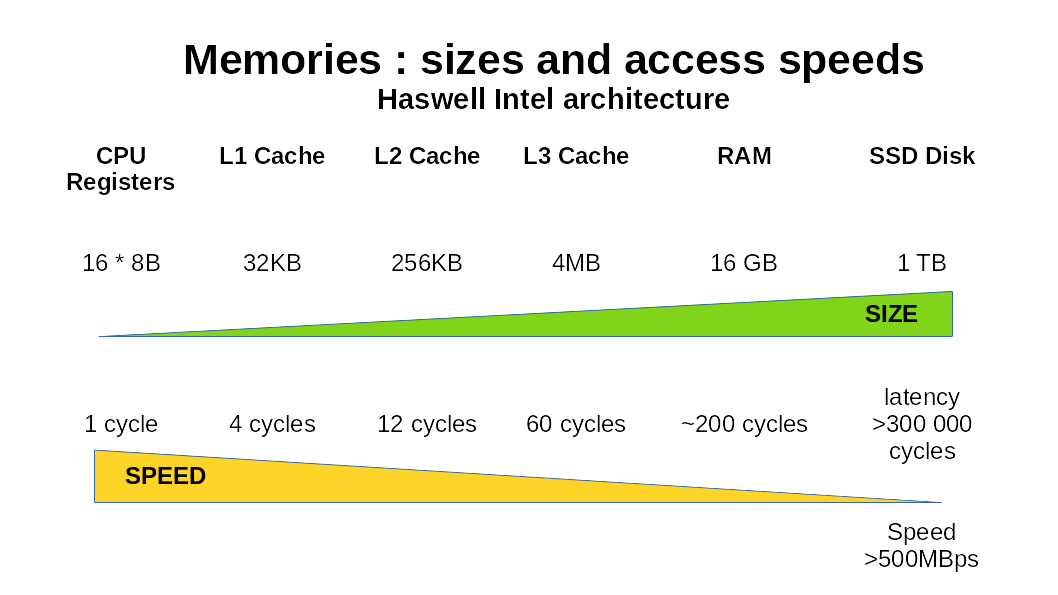

# 2. Three examples of parallel computing in Python

## 2.1 User-friendly parallelization whit `scikit-learn`

In [ ]:
%matplotlib inline
import numpy
import numpy.random
import time

from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=0, n_clusters_per_class=1, n_samples=1000000)

In [ ]:
n_list = [1, 2, 3, 4]
print("Processing ...")
for n_process in n_list :
    ## Creating the classifier :
    clf = KNeighborsClassifier(n_jobs = n_process)

    start_time = time.time()
    ## Estimating its best parameters :
    clf.fit(X, y)
    ## Applying the classifier on the dataset itself :
    y_est = clf.predict(X)
    stop_time = time.time()
    print(n_process, 'process(es) : Elapsed time : ', stop_time-start_time)
    time.sleep(3)
    
## Getting some figures from the last classifier :
print("Number of samples : ",len(y))
print("Classification score:", clf.score(X,y))

### Why  is the parallel execution not 4 times faster ?
* initialization / communication takes time
* not all the algorithm can be parallelized
* CPU cores are occupied with other process
* ...

We can see on CPU loads that the portion of initialization is important

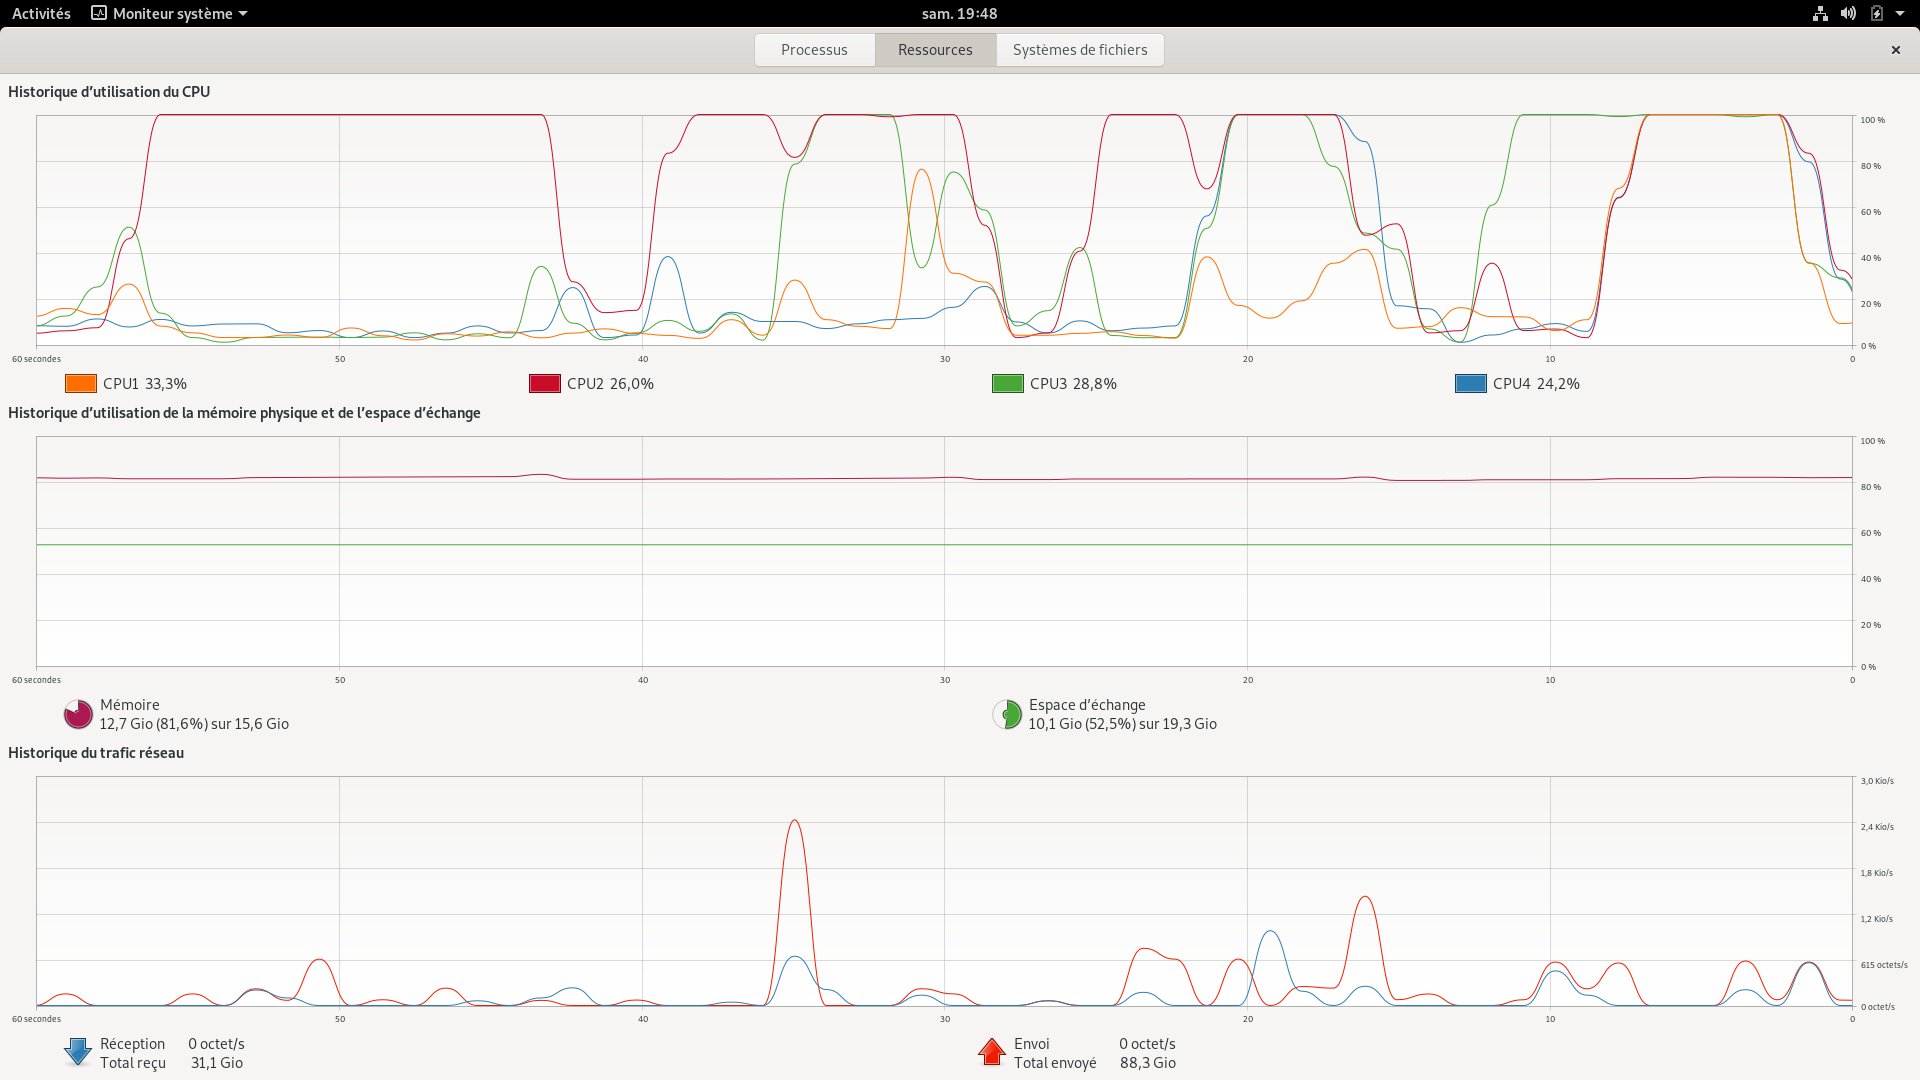

## 2.2 Hand made example in IPython : `ipyparallel`

### <span style="color:red;">First of all</span> : Installation of <tt>ipyparallel</tt> and starting a "cluster"

In a **<u>Shell</u>** command line : 
1. Install ipyparallel module : **<tt>conda install ipyparallel</tt>**
1. Start a "cluster" for parallel computing, if your CPU has 4 cores : **<tt>ipcluster start -n 4<tt>**

To study further :
* [<tt>ipyparallel</tt> documentation](http://ipyparallel.readthedocs.io/en/latest/index.html)
* [<tt>ipyparallel</tt> examples](https://github.com/ipython/ipyparallel/tree/master/examples)

### Example 1 : generate random numbers 

In [ ]:
############## BEWARE : %timeit is slowing computation down ##############
import time
import ipyparallel as ipp

print("Initializing ...")
cpu_tot = 4
array_length = 1000000

## Here we are creating 4 engines running independant Ipython (in addition of Ipython running this notebook)
clients = ipp.Client()
view=clients[0:cpu_tot]
print(clients.ids, type(clients), type(view))
print(view)
with view.sync_imports():  ## importing directly is not enough, 
    import numpy           ## because there is an instance of IPython running on each engine
    
def rand_vec(el_nb=1000000) :
    return numpy.random.randn(el_nb)



print('Working ...')
one_cpu_array = rand_vec(cpu_tot * array_length)
print('---------- One CPU ---------- ')
%timeit yy = rand_vec(cpu_tot * array_length)
time.sleep(1)

print('----------',cpu_tot, 'CPUs ---------- ')
four_cpu_array = view.apply_sync(rand_vec,)
%timeit zz = view.apply_sync(rand_vec,array_length)
print('Done')


### Why is the parallel execution  not 4 times faster ?

This time all the algortihm can be parallelized, but once again :
* initialization / communication takes time
* CPU cores are occupied with other process

And some other reasons exist :
* each CPU core is also running IPython
* numpy vectorization is efficient
* ...

Here you can see that the parallel execution used the four CPU : 
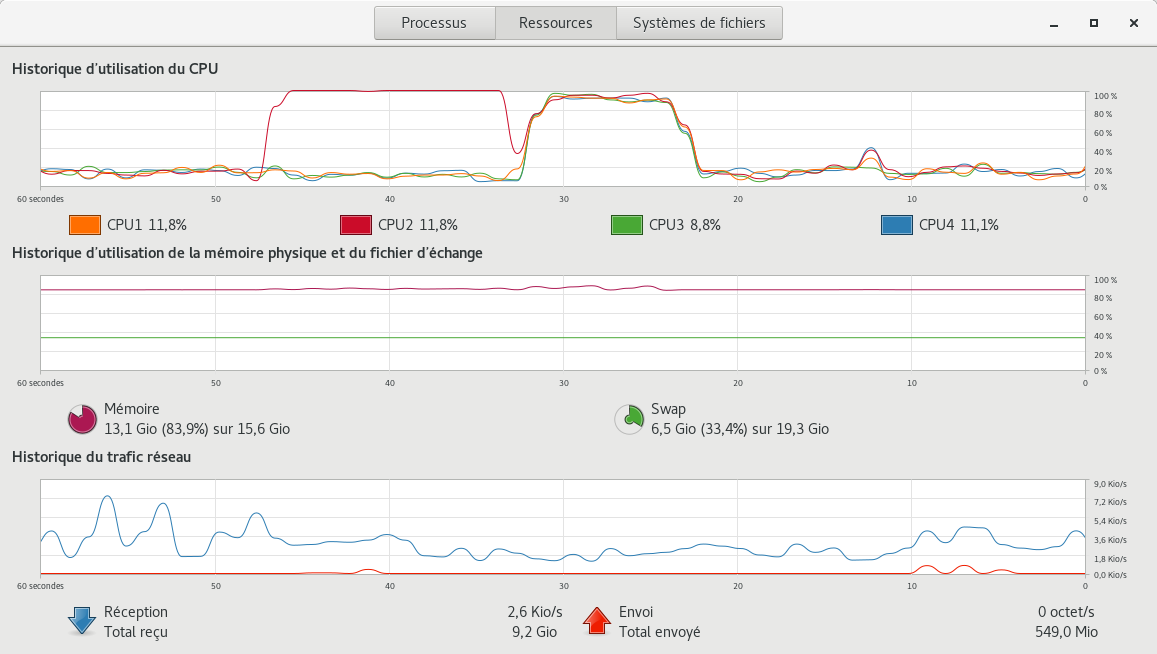

We can check the results

In [ ]:
print(len(one_cpu_array))
print(len(four_cpu_array[0]), len(four_cpu_array[1]), len(four_cpu_array[2]), len(four_cpu_array[3]))
print(four_cpu_array[0][:5], four_cpu_array[1][:5])

### Example 2 :  calling a function with different arguments on each engine


In [ ]:
import ipyparallel as ipp
clients = ipp.Client()
view = clients[:]

def add_100(g_var) :
    g_var[0]+=100
    return g_var

arg1 = [11, 12, 13, 14, 15, 16, 17, 18]
view.scatter('g_var', arg1)
res = view.apply(add_100, ipp.Reference('g_var'))
print(res.get())

### Exercise : parallel merge sort
Merge sort algorithm is based upon splitting, then sorting in merging. 

For example is you want to sort : **[12, 74, 2, 3, 69, 34, 69, 56]**

    S          [12, 74, 2, 3, 69, 34, 69, 56]
    P      
    L          [12, 74, 2, 3]            [69, 34, 69, 56]
    I      
    T          [12, 74]      [2, 3]      [69, 34]     [69, 56]
         M     [12]   [74]   [2]   [3]   [69]  [34]   [69]   [56]
         E     [12, 74]      [2, 3]      [34, 69]     [56, 69]
         R  
         G     [2, 3, 12, 74]            [34, 56, 69, 69]
         E     [2, 3, 12, 34, 56, 69, 69, 74]
      
      

 You can find below a *recursive* implementation of a merge sort algorithm.

**TO DO** :
* Execute it on one core
* Execute it on 4 cores
* Compare the execution time. 

**Hints** :
* You can execute a cell on all engines if the first line is the magic command **<tt>%%px</tt>**
* You may need more : **<tt>%%px</tt>** may take an option (see [here](https://github.com/ipython/ipyparallel/blob/master/examples/Parallel%20Magics.ipynb) )
* Use the **<tt>view.wait()</tt>** function
* After parallel executions you need to merge results, the same way the **<tt>merge_sort</tt>** function does

In [ ]:
import ipyparallel as ipp
import numpy 
import time

clients = ipp.Client()
view = clients[:]
print(clients.ids)

In [ ]:
                            
## ^^^^ You have to write a special line on the first line 
def merge_sort(a_list) :
    if len(a_list)>1 :  
        # splitting list in two pieces + recursive call
                                                         ### COMPLETE SEVERAL LINES HERE

        # merging left_list and right_list
        ind_l=0
        ind_r=0
        out_list=[]
                                                        ### COMPLETE SEVERAL LINES HERE
        
        
        
        
        
        
        return out_list
    else :
        return a_list

In [ ]:
arg1 = list(numpy.random.randn(100000))

############## YOU MAY NEED A FUNCTION HERE ###############


### only ONE core ###
start_time = time.time()
merge_sort(arg1)
stop_time = time.time()
print('Elapsed time : ', stop_time-start_time)

start_time = time.time()
### SEVERAL cores ###
############### WRITE SEVERAL LINES HERE ###################


stop_time = time.time()
print('Elapsed time : ', stop_time-start_time)


In [ ]:
help(view.wait)

### Bonus : test the speed differences
with the code below ...

In [ ]:
def naive_max(a_list) :
    el_max = a_list[0]
    for el in a_list :
        if el > el_max :
            el_max = el
    return el_max
        
def just_a_loop(iter_tot) :
    iter_num = 0
    while iter_num < iter_tot[0]:
        iter_num += 1
    return iter_num
        

###### INITIALIZATION : CHANGE PARAMETERS #########
arg1 = list(numpy.random.randn(1000000))
nb_of_iter = 10000000

nb_cpu = 2
max_func = False

######## Non parallel ##########
start_time = time.time()
if max_func == True :
    naive_max(arg1)
else: 
    just_a_loop([nb_cpu*nb_of_iter])
stop_time = time.time()
print('Elapsed time : ', stop_time-start_time)

######## Parallel ##########
view = clients[0:nb_cpu]
if max_func == True :
    view.scatter('s_arg', arg1)
else :
    view.scatter('s_arg', nb_cpu*[nb_of_iter])

start_time = time.time()
if max_func == True :
    res = view.apply(naive_max, ipp.Reference('s_arg'))
else :
    res = view.apply(just_a_loop, ipp.Reference('s_arg'))
view.wait(res)

stop_time = time.time()
print('Elapsed time : ', stop_time-start_time)
res.get()

## 2.3 Accelerating computation using GPU

A GPU (graphical processing unit) is a processor specialised for graphics. As such it is optimised to perform a very high level of parallel computing, with a **SIMD** approach : _Single instruction, multiple data_.

You can use the computing power of this unit to perform embarassingly parallel computation.

Performing the initialisation computation of hierarchical clustering is a typical case of _embarassingly parallel_ computation. The initialisation consist in computing the $(N-1)(N-2)/2$ distances between all possible pairs of $N$ points.

There are multiple ways to use GPU for _general purpose_ programming (termed _GP-GPU_). Amongst other you have:

* CUDA, low level (C like), vendor specific (Nvidia only) platform
* OpenCL, low level (C like), open standard (Nvidia, AMD, intel) platform
* OpenMP, mid level (directive extension to C), open standard platform
* OpenACC, mid level …
* Torch, high level framework …

We will be having a few test using OpenCL

## OpenCL access from Python

The standard interface to OpenCL in Python is `pyopencl`.

This can be installed from the `anaconda navigator` (in the `Environments` tab).

This module is documented [here](https://documen.tician.de/pyopencl/). It provides an example, lets try it.

### <span style="color:red;">Installations NEEDED</span> 
### Linux `opencl` and `pyopencl` installation :  <span style="color:red;">ONLY AN EXAMPLE</span>

#### Find what is your video card model ?
``` 
$ lspci
00:00.0 Host bridge: Intel Corporation Broadwell-U Host Bridge -OPI (rev 09)
00:02.0 VGA compatible controller: Intel Corporation HD Graphics 5500 (rev 09)
```

**My** video card is **HD Graphics 5500**

#### Install "Installable client driver" (ICD) for *YOUR* graphic card, <span style="color:red;">BEWARE</span> here are the commands for *MINE* 

```
$ sudo apt-get install ocl-icd-libopencl1
$ wget https://github.com/intel/compute-runtime/releases/download/19.09.12487/intel-gmmlib_18.4.1_amd64.deb
$ wget https://github.com/intel/compute-runtime/releases/download/19.09.12487/intel-igc-core_19.07.1542_amd64.deb 
$ wget https://github.com/intel/compute-runtime/releases/download/19.09.12487/intel-igc-opencl_19.07.1542_amd64.deb 
$ wget https://github.com/intel/compute-runtime/releases/download/19.09.12487/intel-opencl_19.09.12487_amd64.deb 
$ wget https://github.com/intel/compute-runtime/releases/download/19.09.12487/intel-ocloc_19.09.12487_amd64.deb
```
Then install all these ".deb" : `dpkg -i ...`

#### Install `pyopencl` with `conda`
First : let conda know you installed an "ICD"
```
ln -s /etc/OpenCL/vendors /home/anaconda/anaconda3/etc/OpenCL/vendors
```
Then install pyonpencl :
```
conda config --add channels conda-forge
conda install pyopencl
```


In [ ]:
from __future__ import absolute_import, print_function
import numpy as np
import pyopencl as cl

a_np = np.random.rand(50000).astype(np.float32)
b_np = np.random.rand(50000).astype(np.float32)

ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)

mf = cl.mem_flags
a_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=a_np)
b_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=b_np)

prg = cl.Program(ctx, """
__kernel void sum(
    __global const float *a_g, __global const float *b_g, __global float *res_g)
{
  int gid = get_global_id(0);
  res_g[gid] = a_g[gid] + b_g[gid];
}
""").build()

res_g = cl.Buffer(ctx, mf.WRITE_ONLY, a_np.nbytes)
prg.sum(queue, a_np.shape, None, a_g, b_g, res_g)

res_np = np.empty_like(a_np)
cl.enqueue_copy(queue, res_np, res_g)

# Check on CPU with Numpy:
print(res_np - (a_np + b_np))
print(np.linalg.norm(res_np - (a_np + b_np)))

But the best is to adapt it so that we can check which device we have handy to perform OpenCL computations and choose the one we want.

In [ ]:
print("Getting the platform(s) available :")
for i, p in enumerate(cl.get_platforms()) :
    print(i, ":", p.get_info(cl.platform_info.NAME))

In [ ]:
## For a given platform, explore devices :
p = cl.get_platforms()[0]

for i, d in enumerate(p.get_devices()) :
    print(i, ":", d.get_info(cl.device_info.NAME))

In [ ]:
## On this computer, the 'best' is [2], we will use it
d = p.get_devices()[0]
print("We will be using device :", d.get_info(cl.device_info.NAME))
print("Available memory (MB):", d.get_info(cl.device_info.GLOBAL_MEM_SIZE)/1024/1024)
print("Available local memory (kB):", d.get_info(cl.device_info.LOCAL_MEM_SIZE)/1024)
print("Available compute unit :", d.get_info(cl.device_info.MAX_COMPUTE_UNITS))
print("Max WG-size :", d.get_info(cl.device_info.MAX_WORK_GROUP_SIZE))
print("Max WI-sizes :", d.get_info(cl.device_info.MAX_WORK_ITEM_SIZES))
print("Memory alignment (float):", d.get_info(cl.device_info.MIN_DATA_TYPE_ALIGN_SIZE)/4)

ctx = cl.Context([d])
queue = cl.CommandQueue(ctx)
mf = cl.mem_flags

We need to have some data to perform the computation : we will use the same example as when using `pdist`, and we will perform the pariwise distance computation on the GPU

In [ ]:
import h5py
import numpy

f = h5py.File("spectral_image.h5", 'r')
d=f["/spectral/image2"][:,:,:] ## To make it a numpy array
print("dimensions of the spectral image :", d.shape)

d_2d = d.reshape((numpy.prod(d.shape[0:2]), d.shape[2]), order='C').astype(numpy.float32)
## Need to reduce it to 1760 to have a proper alignement (other pad to 1792)
d_2d = d_2d[:, 0:1760]
print(d_2d.shape)
d_1d = d_2d.reshape(-1, order='C')
print("image size (MB):", d_1d.shape[0]*4/1024/1024)

In [ ]:
## We need to transfer the data to the GPU to be able to process on it:
image_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=d_1d.astype(numpy.float32))

The idea is to compute a distance matrix in exactly the same way that `pdist` is doing so we can input it to the `linkage` function directly (sparing the computation of the initialisation matrix by `linkage`).

The tricky part is to check in which order are the output results, this is visible in the [sources](https://github.com/scipy/scipy/blob/master/scipy/spatial/distance.py) of `pdist`:

```
        k = 0
        for i in xrange(0, m - 1):
            for j in xrange(i + 1, m):
                dm[k] = metric(X[i], X[j], **kwargs)
                k = k + 1
```

We will replace the inner part of this loop by OpenCL code

In [ ]:
## Arguments of the 'kernel' are as follow :
# * image data (d_1d) : g_data
# * the number of channels in a spectrum (l=1760) : c_spec_size
# * the number of pixel in the image (m=50*75=3750) : c_im_size
# * the index i (outer loop index) : c_i
# * a buffer to hold the results : g_res

prg = cl.Program(ctx, """
__kernel void l2dist(
    __global const float *g_data,
    __const uint c_spec_size,
    __const uint c_im_size,
    __const uint c_i,
    __global float *g_res)
{
    uint  j = get_global_id(0);
    float res = 0.0f;
    __global const float *sp_i_base = g_data + (c_i*c_spec_size);
    __global const float *sp_j_base = g_data + ((j + c_i + 1)*c_spec_size);
    float diff;
    
    for (uint k=0; c_spec_size != k; ++k) {
        diff = (sp_i_base[k] - sp_j_base[k]);
        res += diff * diff;
    }
    g_res[j] = sqrt(res);
}
""").build()

l2dist_knl=prg.l2dist

In [ ]:
print(numpy.uint32(d_2d.shape[1]), numpy.uint32(d_2d.shape[0]), numpy.uint32(i))

In [ ]:
%%time
## Preparing the global result (sticking to pdist sources) :
m = d_2d.shape[0]
dm = np.empty((m * (m - 1)) // 2, dtype=np.double)

res_g = cl.Buffer(ctx, mf.WRITE_ONLY, m*4) ## float are 4B long
res_np = numpy.empty(m, dtype=numpy.float32)

## And looping :
k = 0
for i in range(0, m - 1):
    ## Replacing inner loop by OpenCL :
    l2dist_knl.set_args(image_g, numpy.uint32(d_2d.shape[1]),
                        numpy.uint32(d_2d.shape[0]), numpy.uint32(i),
                        res_g)
    cl.enqueue_nd_range_kernel(queue, l2dist_knl, [m-(i+1)], None)
    cl.enqueue_copy(queue, res_np, res_g)
    
    dm[range(k, k+m-(i+1))] = res_np[range(0, m-(i+1))]
    k = k + m-(i+1)


In [ ]:
%%time
import numpy
import math
from scipy.spatial.distance import euclidean
d_2d_f = d_2d.astype(numpy.float32)
Z = np.empty((m * (m - 1)) // 2, dtype=np.float32)

k = 0
for i in range(0, m - 1):
    for j in range(0, m-(i + 1)):
        Z[k] = math.sqrt(numpy.sum((d_2d_f[i,] - d_2d_f[j+i+1,]) * (d_2d_f[i,] - d_2d_f[j+i+1,])))
        k = k + 1

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.hist(Z-dm)

In [ ]:
%%time

from scipy.spatial.distance import pdist

Z2 = pdist(d_2d_f, metric="euclidean")

In [ ]:
plt.hist(Z-Z2)

In [ ]:
%%time
from scipy.cluster.hierarchy import dendrogram, linkage

clusters_chi2_a=linkage(dm, method="ward")

In [ ]:
%%time
clusters_chi2_b=linkage(Z, method="ward")

In [ ]:
%%time
clusters_chi2_c=linkage(Z2, method="ward")

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('pixel index')
plt.ylabel('distance')
dendrogram(
    clusters_chi2_a,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=100,  # show only the last p merged clusters
    no_labels=True,
    color_threshold=1.5e5,

)
plt.show()

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('pixel index')
plt.ylabel('distance')
dendrogram(
    clusters_chi2_b,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=100,  # show only the last p merged clusters
    no_labels=True,
    color_threshold=1.5e5,

)
plt.show()

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('pixel index')
plt.ylabel('distance')
dendrogram(
    clusters_chi2_c,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=100,  # show only the last p merged clusters
    no_labels=True,
    color_threshold=1.5e5,

)
plt.show()

In [ ]:
from scipy.cluster.hierarchy import fcluster

seg = fcluster(clusters_chi2_a, 4, criterion='maxclust').reshape(d.shape[0:2], order="C")
plt.figure(figsize=(10, 7))
plt.imshow(seg)
plt.title("4 classes")

In [ ]:
from scipy.cluster.hierarchy import fcluster

seg = fcluster(clusters_chi2_b, 4, criterion='maxclust').reshape(d.shape[0:2], order="C")
plt.figure(figsize=(10, 7))
plt.imshow(seg)
plt.title("4 classes")

In [ ]:
from scipy.cluster.hierarchy import fcluster

seg = fcluster(clusters_chi2_c, 4, criterion='maxclust').reshape(d.shape[0:2], order="C")
plt.figure(figsize=(10, 7))
plt.imshow(seg)
plt.title("4 classes")

### Trying to get faster OpenCL

To have better speed we should provide *more work at once* to the GPU. One solution is to perform also the outer loop in `OpenCL`

```
        k = 0
        for i in xrange(0, m - 1):
            for j in xrange(i + 1, m):
                dm[k] = metric(X[i], X[j], **kwargs)
                k = k + 1
```

For a given (i, j) pair the result goes at $\frac{m(m-1)}{2} - \frac{(m-i)(m-i-1)}{2} + j = \frac{m^2-m - (m^2-2mi+i^2-m+i)}{2} + j = \frac{2mi-i^2-i}{2} + j = \frac{i(2m-i-1)}{2} + j$

In [ ]:
## Arguments of the 'kernel' are as follow :
# * image data (d_1d) : g_data
# * the number of channels in a spectrum (l=1760) : c_spec_size
# * the number of pixel in the image (m=50*75=3750) : c_im_size
# * a buffer to hold the results : g_res

## Notice : 2D work-items, index are the 'outer and inner loop index' (i and j)
prg2 = cl.Program(ctx, """
__kernel void l2dist(
    __global const float *g_data,
    __const uint c_spec_size,
    __const uint c_im_size,
    __global float *g_res)
{
    uint  i = get_global_id(0);
    uint  j = get_global_id(1)+1;
    if ( j > i ) { // Otherwise no computation to be done
        float res = 0.0f;
        __global const float *sp_i_base = g_data + (i * c_spec_size);
        __global const float *sp_j_base = g_data + (j * c_spec_size);
        float diff;
    
        for (uint k=0; c_spec_size != k; ++k) {
            diff = (sp_i_base[k] - sp_j_base[k]);
            res += diff * diff;
        }
        // Putting the result at the proper place :
        uint res_place = (i*(2*c_im_size - i - 1))/2 + (j-i);
        g_res[res_place] = sqrt(res);
    }
}
""").build()

l2dist_knl2=prg2.l2dist

Performing the full computation in a single OpenCL run

In [ ]:
%%time
## Preparing the global result (sticking to pdist sources) :
m = d_2d.shape[0]
dm2 = numpy.empty((m * (m - 1)) // 2, dtype=numpy.double)

res_g = cl.Buffer(ctx, mf.WRITE_ONLY, dm2.size*4) ## float are 4B long
print("Size of the result array is approximately", dm2.size*4/1024//1024, "MB")
res_np = numpy.empty(dm2.size, dtype=numpy.float32)

## We need to transfer the data to the GPU to be able to process on it:
image_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=d_1d.astype(numpy.float32))

In [ ]:
%%time
## No looping (all done in a single OpenCL kernel) :
l2dist_knl2.set_args(image_g, numpy.uint32(d_2d.shape[1]), numpy.uint32(d_2d.shape[0]), res_g)
cl.enqueue_nd_range_kernel(queue, l2dist_knl2, (m-1, m-1), None)

## Getting the computed verion ou the GPU for CPU usage :
cl.enqueue_copy(queue, res_np, res_g)
## Copying everything over to the buffer :    
dm[:] = res_np[:]

In [ ]:
## Done with the result buffer, release them :
res_g.release()
image_g.release()

In [ ]:
## Both dm and dm2 are done "natively" on the same CPU:
plt.hist(dm-dm2)

### Copyright
Copyright (C)  2017-2020  Serge Cohen, Bertrand Monfort, Frédéric-Emmanuel Picca under GDFL <a class="anchor" id="GFDL"></a>

Permission is granted to copy, distribute and/or modify this document under the terms of the GNU Free Documentation License, Version 1.3 or any later version published by the Free Software Foundation;   
with no Invariant Sections, no Front-Cover Texts, and no Back-Cover Texts.

A copy of the license is included in the section entitled "[GNU Free Documentation License](https://www.gnu.org/licenses/fdl-1.3-standalone.html)".